# Density estimation

In [149]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

The easiest way to estimate distribution density is to build a histogram. It can be simply implemented and quickly computed, but requires a sufficient number of points and density function is not smooth.

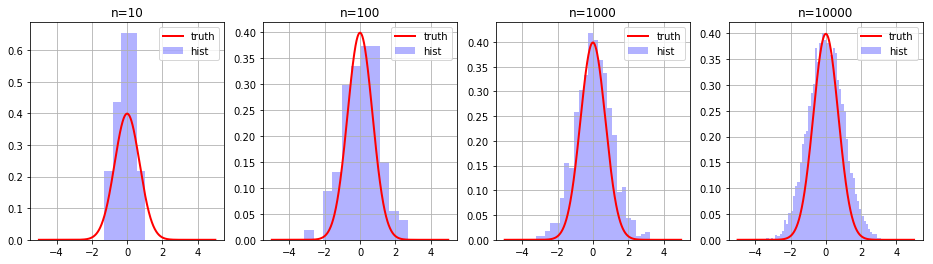

In [150]:
sample_ns = [10, 100, 1000, 10000]

SQRT_2_PI = np.sqrt(2 * np.pi)

x_grid = np.linspace(-5, 5, 1000)
y_true = np.exp(-x_grid*x_grid) / SQRT_2_PI

plt.figure(figsize=(16, 4))
for i, sample_n in enumerate(sample_ns, 1):
    X = np.random.randn(sample_n)
    plt.subplot(1, len(sample_ns), i)
    plt.title(f'n={sample_n}')
    plt.hist(X, bins='auto', normed=True, color='blue', alpha=0.3, label='hist')
    plt.plot(x_grid, y_true, color='red', linewidth=2, label='truth')
    plt.grid()
    plt.legend()

On the other hand, it is possible to estimate the density of distribution with kernel smoothing. You can read more [here](https://en.wikipedia.org/wiki/Kernel_density_estimation). Unfortunately, this approach requires more calculations.

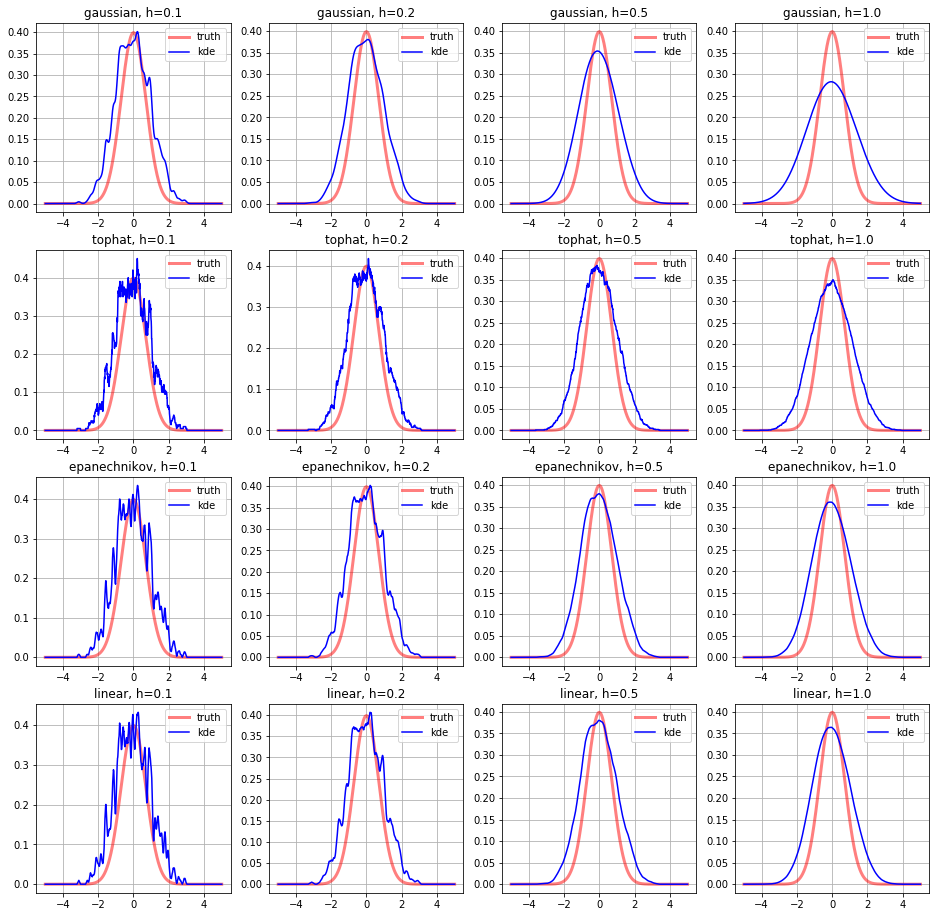

In [151]:
def kde(X_train, X_test, kernel, h):
    density = KernelDensity(bandwidth=h, kernel=kernel)
    density.fit(X_train.reshape(-1, 1))
    return np.exp(
        density.score_samples(X_test.reshape(-1, 1))
    )
                     

kernels = ['gaussian', 'tophat', 'epanechnikov', 'linear']
H = [0.1, 0.2, 0.5, 1.0]
    
X = np.sort(np.random.randn(1000))

plt.figure(figsize=(16, 16))
for i, kernel in enumerate(kernels):
    for j, h in enumerate(H):
        plt.subplot(len(kernels), len(H), i * len(H) + j + 1)
        plt.title(f'{kernel}, h={h}')
        plt.plot(x_grid, y_true, linewidth=3, label='truth', alpha=0.5, color='red')
        plt.plot(x_grid, kde(X, x_grid, kernel, h), color='blue', label='kde')
        plt.grid()
        plt.legend()

There is a parametric estimation of the distribution. This problem is reduced to maximizing logarithm of likelihood. In case where the distribution is a [mixture of several ones](https://en.wikipedia.org/wiki/Mixture_model), you can already use [EM-algorithm](https://en.wikipedia.org/wiki/Expectation–maximization_algorithm).

In [152]:
mu_one = np.array([-1, -1])
mu_two = np.array([2, 2])

V = np.array([[1., 0.],[0., 1.]])

X_one = np.random.multivariate_normal(mu_one, V, 300)
X_two = np.random.multivariate_normal(mu_two, V, 100)


X = np.vstack([X_one, X_two])

In [153]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 0.5, x.max() + 0.5
    y_min, y_max = y.min() - 0.5, y.max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_gaussian(X, mean, cov, color):
    plt.scatter(mean[0], mean[1], marker='*', color=color, s=80)
    
    xx, yy = make_meshgrid(X[:, 0], X[:, 1])
    
    z = sc.stats.multivariate_normal.pdf(np.vstack([xx.ravel(), yy.ravel()]).T, mean=mean, cov=cov)
    z = z.reshape(xx.shape)
    plt.contour(xx, yy, z, colors=[color], linestyles=[':'], linewodth=5)
    

Example for mixture of two gaussian. Plot EM-algorithm step by step.

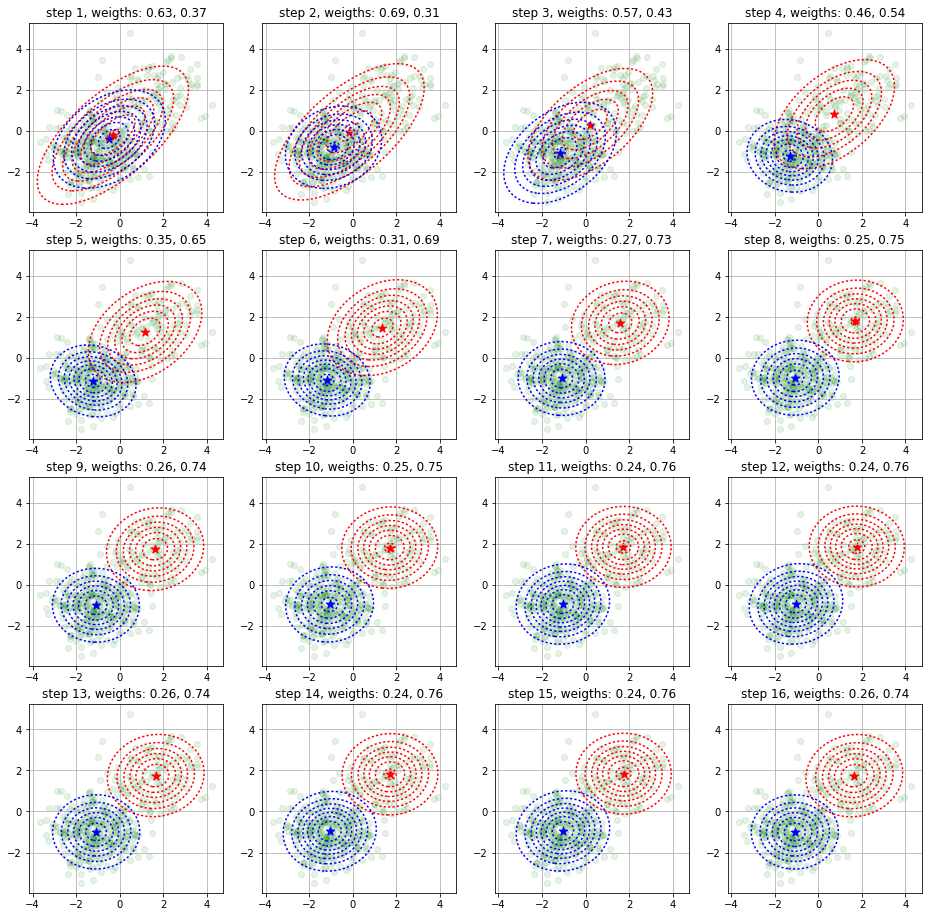

In [154]:
weights = np.array([0.5, 0.5])
means = np.zeros([2, 2])
covs = np.array([np.eye(2)]*2)

H, W = 4, 4


plt.figure(figsize=(16, 16))
for i in range(H*W):
    gmm = GaussianMixture(
        n_components=2,
        max_iter=1,
        weights_init = weights,
        means_init = means
        
    )
    gmm.fit(X)

    weights = gmm.weights_
    means = gmm.means_
    covs = gmm.covariances_

    plt.subplot(H, W, i + 1)
    plt.title(f'step {i + 1}, weigths: {weights[0]:.2}, {weights[1]:.2}')
    plt.scatter(X[:, 0], X[:, 1], color='green', alpha=0.1)
    plot_gaussian(X, gmm.means_[0], gmm.covariances_[0], color='red')
    plot_gaussian(X, gmm.means_[1], gmm.covariances_[1], color='blue')
    plt.grid()